# 基本データ　関数 

In [ ]:
"""
trainをあたはめる際にdataframeの馬番順に直す必要がある

df = df.reset_index().sort_values(["index","馬番"]).set_index("index")
df.index.name = None

"""

In [1]:
import pandas as pd
import time
from tqdm.notebook import tqdm
import pickle
import re 
from urllib.request import urlopen
import numpy as np
import requests
from bs4 import BeautifulSoup 
import matplotlib.pyplot as plt
from itertools import combinations
from itertools import permutations
import warnings
warnings.simplefilter(action="ignore")

import lightgbm as lgb
import optuna
import optuna.integration.lightgbm as lgb_o

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split

In [2]:
results_19 = pd.read_pickle('results_19.pickle')
results_20 = pd.read_pickle('results_20.pickle')
results_21 = pd.read_pickle('results_21.pickle')
results_all = pd.read_pickle('results_all.pickle')
results_all.drop(["cource_len","data"], axis=1, inplace=True)

horse_results = pd.read_pickle('horse_results_19.pickle')
horse_results_20 = pd.read_pickle('horse_results_20.pickle')
horse_results_21 = pd.read_pickle('horse_results_21.pickle')

peds = pd.read_pickle('peds-Copy1.pickle')
peds_all = pd.read_pickle('peds_all.pickle')
n_peds_all = pd.read_pickle('n_peds_all')
n_peds_all2 = pd.read_pickle('n_peds_all2.pickle')

#r.data_cの馬番をsortしたもの　リークをなくすため
r_data_sort = pd.read_pickle("r_data_sort.pickle")

return_tables_19 = pd.read_pickle('Return_tables_19.pickle')
return_tables_20 = pd.read_pickle('Return_tables_20.pickle')
return_tables_21 = pd.read_pickle('Return_tables_21.pickle')
return_tables_all = pd.read_pickle("Return_tables_all.pickle")

In [6]:
horse_results

,日付,開催,天気,R,レース名,映像,頭数,枠番,馬番,オッズ,...,着差,ﾀｲﾑ指数,通過,ペース,上り,馬体重,厩舎ｺﾒﾝﾄ,備考,勝ち馬(2着馬),賞金
2017105318,2021/07/17,1福島5,晴,9.0,南相馬特別(1勝クラス),NaN,16.0,5.0,10,5.2,...,0.9,**,3-3-3-2,34.9-35.9,36.5,532(-38),NaN,NaN,フィデリオグリーン,NaN
2017105318,2020/12/26,5中山7,晴,9.0,立志賞(1勝クラス),NaN,18.0,6.0,12,3.5,...,1.9,**,1-1-1-1,37.5-36.8,38.7,570(+18),NaN,NaN,ルトロヴァイユ,NaN
2017105318,2020/08/02,1札幌4,晴,7.0,3歳以上1勝クラス,NaN,8.0,8.0,8,1.5,...,0.2,**,7-6-4-4,36.6-34.7,34.5,552(+28),NaN,NaN,シャムロックヒル,110.0
2017105318,2019/08/31,2札幌5,曇,11.0,札幌2歳S(G3),NaN,12.0,7.0,10,1.8,...,0.6,**,10-7-7-2,36.0-37.3,37.3,524(+6),NaN,NaN,ブラックホール,NaN
2017105318,2019/07/27,1札幌1,曇,1.0,2歳未勝利,NaN,9.0,1.0,1,1.4,...,-1.8,**,1-1-1-1,35.9-36.5,36.5,518(-16),NaN,NaN,(プントファイヤー),500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017101106,2020/03/14,1阪神5,雨,2.0,3歳未勝利,NaN,13.0,6.0,9,137.1,...,1.6,**,5-5-6-7,38.3-37.1,38.2,460(0),NaN,NaN,サンライズプラウ,NaN
2017101106,2020/02/29,1中京1,曇,2.0,3歳未勝利,NaN,12.0,7.0,10,45.4,...,1.7,**,8-8-10-9,30.6-38.4,38.7,460(-2),NaN,NaN,ワンダークンナパー,NaN
2017101106,2020/02/09,2京都4,晴,2.0,3歳未勝利,NaN,15.0,2.0,3,40.9,...,1.8,**,1-1-1-1,38.3-38.3,40.1,462(0),NaN,NaN,クールインパクト,NaN
2017101106,2020/01/25,1京都8,曇,3.0,3歳未勝利,NaN,11.0,7.0,9,28.0,...,1.6,**,10-9-9-7,36.9-37.8,38.3,462(+14),NaN,NaN,フームスムート,51.0


In [7]:
peds

,peds_0,peds_1,peds_2,peds_3,peds_4,peds_5,peds_6,peds_7,peds_8,peds_9,...,peds_52,peds_53,peds_54,peds_55,peds_56,peds_57,peds_58,peds_59,peds_60,peds_61
2017105318,ヴィクトワールピサ 2007 黒鹿毛 [血統][産駒] Halo系,ゴレラ Gorella(仏) 2002 栗毛 [血統][産駒] FNo.[9-e],ネオユニヴァース 2000 鹿毛 [血統][産駒],ホワイトウォーターアフェア Whitewater Affair(英) 1993 栗毛 [血統...,Grape Tree Road 1993 鹿毛 [血統][産駒],Exciting Times 1997 栗毛 [血統][産駒],サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒],ポインテッドパス Pointed Path(英) 1984 栗毛 [血統][産駒],Machiavellian 1987 黒鹿毛 [血統][産駒],Much Too Risky 1982 栗毛 [血統][産駒],...,Busted,Tina,Northern Dancer,Special,Alydar,Crimson Saint,High Top,Sega Ville,Sir Gaylord,Crepellana
2017104612,エピファネイア 2010 鹿毛 [血統][産駒] Roberto系,プントバンコ 2008 青鹿毛 [血統][産駒] FNo.[10-a],シンボリクリスエス 1999 黒鹿毛 [血統][産駒],シーザリオ 2002 青毛 [血統][産駒],フジキセキ 1992 青鹿毛 [血統][産駒],ポリーズフリート Polly's Fleet(米) 1995 栗毛 [血統][産駒],Kris S. 1977 黒鹿毛 [血統][産駒],Tee Kay 1991 黒鹿毛 [血統][産駒],スペシャルウィーク 1995 黒鹿毛 [血統][産駒],キロフプリミエール Kirov Premiere(英) 1990 鹿毛 [血統][産駒],...,In Reality,Millicent,Raise a Native,Gold Digger,Venetian Jester,Friendly Ways,Northern Dancer,Goofed,Hard Tack,Polly Macaw
2017103879,カジノドライヴ 2005 栗毛 [血統][産駒] Seattle Slew系,フォレノワール 2010 鹿毛 [血統][産駒] FNo.[19-b],Mineshaft (米) 1999 黒鹿毛 [血統][産駒],Better Than Honour 1996 鹿毛 [血統][産駒],アグネスタキオン 1998 栗毛 [血統][産駒],ネームヴァリュー 1998 鹿毛 [血統][産駒],A.P. Indy 1989 黒鹿毛 [血統][産駒],Prospectors Delite 1989 [血統][産駒],Deputy Minister 1979 黒鹿毛 [血統][産駒],Blush With Pride 1979 栗毛 [血統][産駒],...,リマンド,イコマエイカン,In Reality,Foggy Note,Al Nasr,Gonfalon,Bold Reasoning,My Charmer,Graustark,Queen's Paradise
2017106259,クロフネ 1998 芦毛 [血統][産駒] Deputy Minister系,オースミフブキ 2011 鹿毛 [血統][産駒] FNo.[3-l],フレンチデピュティ French Deputy(米) 1992 栗毛 [血統][産駒],ブルーアヴェニュー Blue Avenue(米) 1990 芦毛 [血統][産駒],マンハッタンカフェ 1998 青鹿毛 [血統][産駒],オースミハルカ 2000 鹿毛 [血統][産駒],Deputy Minister 1979 黒鹿毛 [血統][産駒],Mitterand 1981 鹿毛 [血統][産駒],Classic Go Go 1978 黒鹿毛 [血統][産駒],Eliza Blue 1983 芦毛 [血統][産駒],...,Luciano,Suleika,Nijinsky,Foreseer,Sadler's Wells,Sun Princess,Alydar,ベーシイド,プロント,トサモアー
2017104140,オーシャンブルー 2008 鹿毛 [血統][産駒] Halo系,ロックマイハート Rock My Heart(独) 2009 栗毛 [血統][産駒] FNo...,ステイゴールド 1994 黒鹿毛 [血統][産駒],プアプー Peu a Peu(独) 1998 鹿毛 [血統][産駒],Sholokhov 1999 鹿毛 [血統][産駒],Rondinay 2000 栗毛 [血統][産駒],サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒],ゴールデンサッシュ 1988 栗毛 [血統][産駒],Dashing Blade 1987 鹿毛 [血統][産駒],Plains Indian 1991 鹿毛 [血統][産駒],...,Home Guard,Gradiva,Balidar,Brig O'Doon,Sharpen Up,L'Anguissola,Surumu,Aggravate,Prince Ippi,Tania
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017102659,ヘニーヒューズ Henny Hughes(米) 2003 [血統][産駒] Storm Bird系,カワカミプリンセス 2003 鹿毛 [血統][産駒] FNo.[4-m],ヘネシー Hennessy(米) 1993 栗毛 [血統][産駒],Meadow Flyer 1989 鹿毛 [血統][産駒],キングヘイロー 1995 鹿毛 [血統][産駒],タカノセクレタリー 1996 鹿毛 [血統][産駒],Storm Cat (米) 1983 黒鹿毛 [血統][産駒],Island Kitty 1976 栗毛 [血統][産駒],Meadowlake 1983 栗毛 [血統][産駒],Shortley 1980 黒鹿毛 [血統][産駒],...,Sir Ivor,Squander,Boldnesian,Reason to Earn,Poker,Fair Charmer,Bold Ruler,Somethingroyal,Key to the Mint,Summer Guest
2016102166,ゴールドアリュール 1999 栗毛 [血統][産駒] Halo系,タフネスデジタル 2006 鹿毛 [血統][産駒] FNo.[4-d],サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒],ニキーヤ Nikiya(米) 1993 鹿毛 [血統][産駒],アグネスデジタル 1997 栗毛 [血統][産駒],タフネススター 1997 鹿毛 [血統][産駒],Halo 1969 黒鹿毛 [血統][産駒],Wishing Well 1975 鹿毛 [血統][産駒],Nureyev 1977 鹿毛 [血統][産駒],Reluctant Guest 1986 鹿毛 [血統][産駒],...,Alleged,Runaway Bride,Northern Dancer,Nice Princess,Le Haar,ペルシアンプリンセス,アローエクスプレス,キクノホウラン,トピオ,インズキー
2016103450,ヨハネスブルグ Johannesburg(米) 1999 鹿毛 [血統][産駒] Storm...,ニシノモレッタ 2007 栗毛 [血統][産駒] FNo.[2-i],ヘネシー Hennessy(米) 1993 栗毛 [血統][産駒],Myth 1993 鹿毛 [血統][産駒],タイキシャトル 1994 栗毛 [血統][産駒],ミストラスト Mistrust(米) 2001 栗毛 [血統][産駒],Storm Cat (米) 1983 黒鹿毛 [血統][産駒],Island Kitty 1976 栗毛 [血統][産駒],オジジアン Ogygian(米) 1983 鹿毛 [血統][産駒],Yarn 1987 鹿毛 [血統][産駒],...,Thatch,Contrail,Red God,Runaway Bride,Bustino,Highclere,Northern Dancer,Fleur,Quadrangle,Lucretia Bori
2017105662,オルフェーヴル 2008 栗毛 [血統][産駒] Halo系,ローブティサージュ 2010 青毛 [血統][産駒] FNo.[8-d],ステイゴールド 1994 黒鹿毛 [血統][産駒],オリエンタルアート 1997 栗毛 [血統][産駒],ウォーエンブレム War Emblem(米) 1999 青鹿毛 [血統][産駒],プチノワール 2005 

In [3]:
#min_thresholdの値から1までを100等分する
def gain(return_func, X, n_samples=100, range_=[0.5, 3.5]):
    gain = {}
    for i in tqdm(range(n_samples)):
        threshold = range_[1] * i / n_samples + range_[0] * (1 - (i / n_samples))
        n_bets, return_rate, n_hits, std = return_func(X, threshold)
        if n_bets > 2:
            gain[threshold] = {"return_rate":return_rate,
                                "n_hits":n_hits,
                                "std":std,
                                "n_bets":n_bets}
    return pd.DataFrame(gain).T

# yearに値を入れればいい
def race_id_c(year):
    race_id_list = []
    
    race_id_head = year
    for place in range(1,11,1):
        for kai in range(1,6,1):
            for day in range(1,13,1):
                for r in range(1,13,1):
                    race_id = str(place).zfill(2) + str(kai).zfill(2) +\
                    str(day).zfill(2) + str(r).zfill(2)
                    race_ids = race_id_head + race_id
                    race_id_list.append(race_ids)
    return race_id_list

def split_data(df, test_size=0.3):
    sorted_id_list = df.sort_values("date").index.unique()
    train_id_list = sorted_id_list[: round(len(sorted_id_list) * (1 - test_size))]
    test_id_list = sorted_id_list[round(len(sorted_id_list) * (1 - test_size)) :]
    train = df.loc[train_id_list]#.drop(['date'], axis=1)
    test = df.loc[test_id_list]#.drop(['date'], axis=1)
    return train, test

def plot(df, label=' '):
    plt.fill_between(df.index, y1=df['return_rate']-df['std'],
        y2=df['return_rate']+df['std'],alpha=0.3)
 
    plt.plot(df.index, df['return_rate'], label=label)
    plt.legend()
    plt.grid(True)

place_dict = {
    '札幌':'01',  '函館':'02',  '福島':'03',  '新潟':'04',  '東京':'05', 
    '中山':'06',  '中京':'07',  '京都':'08',  '阪神':'09',  '小倉':'10'
}

race_type_dict = {
    '芝': '芝', 'ダ': 'ダート', '障': '障害'
}

# DataProcessor

In [4]:
class DataProcessor:
    def __init__(self):
        self.data = pd.DataFrame() # raw data
        self.data_p = pd.DataFrame() #after preprocessing
        self.data_h = pd.DataFrame() #after merging horse_results
        self.data_pe = pd.DataFrame() #after merging peds
        self.data_c = pd.DataFrame() #after processing categorical features
        self.data_ = pd.DataFrame()
        #self.no_peds #親データがないhorse_id_list
    
    # 馬の過去成績のデータ追加    
    def merge_horse_results(self, hr, n_samples_list=[5, 9, 'all']):
        self.data_h = self.data_p.copy()
        for n_samples in n_samples_list:
            self.data_h = hr.merge_all(self.data_h, n_samples=n_samples)
            
        #self.data_h["interval"] = (self.data_h["data"] - self.data_h["latest"]).dt.days
        self.data_h.drop(["開催"],axis=1, inplace=True)
    
    # 馬の親データの追加                
    def merge_peds(self, peds):
        self.data_pe = self.data_h.merge(peds,left_on='horse_id',
        right_index=True, how='left')
        
        self.no_peds = self.data_pe[self.data_pe['peds_0'].isnull()]\
            ['horse_id'].unique()
        if len(self.no_peds) > 0:
            print('scrape peds at horse_id_list "no_peds"')
    
    # 質的変数への変換        
    def process_categorical(self, le_horse, le_jockey, results_m):
        df = self.data_pe.copy()
        
        #ラベルエンコーディング　horse_id,jockey_idを0始まりの整数に変換
        mask_horse = df['horse_id'].isin(le_horse.classes_)
        new_horse_id = df['horse_id'].mask(mask_horse).dropna().unique()
        le_horse.classes_ = np.concatenate([le_horse.classes_, new_horse_id])
        df['horse_id'] = le_horse.transform(df['horse_id'])
        
        mask_jockey = df['jockey_id'].isin(le_jockey.classes_)
        new_jockey_id = df['jockey_id'].mask(mask_jockey).dropna().unique()
        le_jockey.classes_ = np.concatenate([le_jockey.classes_, new_jockey_id])
        df['jockey_id'] = le_jockey.transform(df['jockey_id'])
        
        df["horse_id"] = df["horse_id"].astype('category')
        df["jockey_id"] = df["jockey_id"].astype('category')
        
        weathers = results_m['weather'].unique()
        race_types = results_m['race_type'].unique()
        ground_states = results_m['ground_state'].unique()
        sexes = results_m['性'].unique()
        df['weather'] = pd.Categorical(df['weather'], weathers)
        df['race_type'] = pd.Categorical(df['race_type'], race_types)
        df['ground_state'] = pd.Categorical(df['ground_state'], ground_states)
        df['性'] = pd.Categorical(df['性'], sexes)
        
        df = pd.get_dummies(df, columns=['weather', 'race_type', 'ground_state', '性'])
        #race_idを軸に馬番をsort
        df = df.reset_index().sort_values(["index","馬番"]).set_index('index')
        df.index.name = None
        
        self.data_c = df
     
    
# Results class 
# 足りないhorse_idをスクレイプした際は確認したのちdef to_data_frameを使う必要あり
class Results(DataProcessor):
    def __init__(self, results):
        super(Results, self).__init__()
        self.data = results
    
    # path_listはpickle名
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.read_pickle(path_list[0])
        for path in path_list[1:]:
            df = update_data(df, pd.read_pickle(path))
        return cls(df)
    
    @staticmethod
    def scrape(race_id_list, pre_race_results={}):
        race_results = pre_race_results
        for race_id in tqdm(race_id_list):
            if race_id in race_results.key():
                continue
            
            try:
                time.sleep(1)
                url = "https://db.netkeiba.com/race/" + race_id
                df = pd.read_html(url)[0]
                html = requests.get(url)
                html.encode = "EUC-JP"
                soup = BeautifulSoup(html.text, "html.parser")
                
                texts = (
                    soup.find("div", attrs={"class" : "data_intro"}).find_all("p")[0].tesxt
                    + soup.find("div", attrs={"class" : "data_intro"}).find_all("p")[1].tesxt
                )
                info = re.findall(r"\w+", texts)
                for text in info:
                    if text in ["芝", "ダート"]:
                        df["race_type"] = [text] * len(df)
                    if "障" in text:
                        df["race_type"] = ["障害"] * len(df)
                    if "m" in text:
                        df["course_len"] = [int(re.findall(r"\d+", text)[0])] * len(df)
                    if text in ["良", "稍重", "稍", "重", "不良"]:
                        df["ground_state"] = [text] * len(df)
                    if text in ["曇", "晴", "雨", "小雨", "小雪", "雪"]:
                        df["weather"] = [text] * len(df)
                    if "年" in text:
                        df["date"] = [text] * len(df)
                        
                #馬ID、騎手IDをスクレイピング
                horse_id_list = []
                horse_a_list = soup.find("table", attrs={"summary": "レース結果"}).find_all(
                    "a", attrs={"href": re.compile("^/horse")}
                )
                for a in horse_a_list:
                    horse_id = re.findall(r"\d+", a["href"])
                    horse_id_list.append(horse_id[0])
                jockey_id_list = []
                jockey_a_list = soup.find("table", attrs={"summary": "レース結果"}).find_all(
                    "a", attrs={"href": re.compile("^/jockey")}
                )
                for a in jockey_a_list:
                    jockey_id = re.findall(r"\d+", a["href"])
                    jockey_id_list.append(jockey_id[0])
                df["horse_id"] = horse_id_list
                df["jockey_id"] = jockey_id_list

                #インデックスをrace_idにする
                df.index = [race_id] * len(df)
                
                race_results[race_id] = df 
                
            except IndexError:
                continue
            except Exception as e:
                print(e)
                break
            except:
                break
        return race_results
        # 一度dataframe型に直さずに出力を返す        
        #return race_results
        
    def to_data_frame(race_results):
        race_results_df = pd.concat([race_results[key] for key in race_results])

        return race_results_df
        
        
        
    # to_dataframe関数で出力後にdataframe型に変換が可能            
    #def to_dataframe(race_results):
        #race_results_df = pd.concat([race_results[key] for key in race_results])
        
        #r.data_rr = race_results_df                    
                
    # regressionをtrueにすることでsecond,着順が表示され回帰が行える。
    def preprocessing(self, regression=False):
        df = self.data.copy()

        # 着順に数字以外の文字列が含まれているものを取り除く
        df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
        df.dropna(subset=['着順'], inplace=True)
        df['着順'] = df['着順'].astype(int)
        df['rank'] = df['着順'].map(lambda x: 1 if x < 4 else 0)

        # 性齢を性と年齢に分ける
        df["性"] = df["性齢"].map(lambda x: str(x)[0])
        df["年齢"] = df["性齢"].map(lambda x: str(x)[1:]).astype(int)

        # 馬体重を体重と体重変化に分ける (馬体重修正するかも)
        df["体重"] = df["馬体重"].str.split("(", expand=True)[0].astype(int)
        df["体重変化"] = df["馬体重"]\
            .str.split("(", expand=True)[1].replace("前計不", "0").str[:-1].astype(dtype = int)

        # データをint, floatに変換
        df["単勝"] = df["単勝"].astype(float)
        df['course_len'] = df['course_len'].astype(float) // 100

        # 不要な列を削除
        # 回帰子を作るために一時的に着順,タイムの列を削除しない。
        # df.drop(["タイム", "着差", "調教師", "性齢", "馬体重","馬名","騎手","人気","着順"], axis=1, inplace=True)
        df.drop(["着差", "調教師", "性齢", "馬体重","馬名","騎手","人気"], axis=1, inplace=True)

        df["date"] = pd.to_datetime(df["date"], format="%Y年%m月%d日")
        
        df["タイム"].fillna("0", inplace=True)
        df["a"] = df["タイム"].map(lambda x:re.sub(r"\D", "", x)).astype(str)
        df["second"] = df["a"].map(lambda x: 0 if x=="0" \
        else (int(x[0]) * 60) + int(x[1:3]) + int(x[1:])/10).astype(float)
        df.drop("a", axis=1 ,inplace=True)
        df.drop(["タイム"],axis=1, inplace=True)
        
        df["rls"] = df["second"]\
        .map(lambda x: np.sqrt(np.log(x)))
        
        df['開催'] = df.index.map(lambda x: str(x)[4:6])
        
        df["n_horses"] = df.index.map(df.index.value_counts())
        
        if regression == True:
            self.data_p = df
        else:
            self.data_p = df.drop(["second","着順","rls"],axis=1)
    
    def process_categorical(self):
        self.le_horse = LabelEncoder().fit(self.data_pe['horse_id'])
        self.le_jockey = LabelEncoder().fit(self.data_pe['jockey_id'])
        super().process_categorical(self.le_horse, self.le_jockey, self.data_pe)
  
    
# ShutubaTable class        
class ShutubaTable(DataProcessor):
    def __init__(self, shutuba_tables):
        super(ShutubaTable, self).__init__()
        self.data = shutuba_tables
        
    @classmethod    
    def scrape(cls, race_id_list, date):
        data = pd.DataFrame()
        for race_id in tqdm(race_id_list):
            
            url = 'https://race.netkeiba.com/race/shutuba.html?race_id=' + race_id
            df = pd.read_html(url)[0]
            df = df.T.reset_index(level=0, drop=True).T
            
            html = requests.get(url)
            html.encoding = "EUC-JP"
            soup = BeautifulSoup(html.text, "html.parser")
            
            texts = soup.find("div", attrs={"class":"RaceData01"}).text
            texts = re.findall(r"\w+", texts)
            for text in texts:
                if 'm' in text:
                    df['course_len'] = [int(re.findall(r'\d+', text)[0])] * len(df)
                if text in ["曇", "晴", "雨", "小雨", "小雪", "雪"]:
                    df["weather"] = [text] * len(df)
                if text in ["良", "稍重", "稍", "重"]:
                    df["ground_state"] = [text] * len(df)
                if '不' in text:
                    df["ground_state"] = ['不良'] * len(df)
                if '芝' in text:
                    df['race_type'] = ['芝'] * len(df)
                if '障' in text:
                    df['race_type'] = ['障害'] * len(df)
                if 'ダ' in text:
                    df['race_type'] = ['ダート'] * len(df)
            df['date'] = [date] * len(df)
            
            # horse_id
            horse_id_list = []
            horse_td_list = soup.find_all("td", attrs={'class': 'HorseInfo'})
            for td in horse_td_list:
                horse_id = re.findall(r'\d+', td.find('a')['href'])[0]
                horse_id_list.append(horse_id)
            # jockey_id
            jockey_id_list = []
            jockey_td_list = soup.find_all("td", attrs={'class': 'Jockey'})
            for td in jockey_td_list:
                jockey_id = re.findall(r'\d+', td.find('a')['href'])[0]
                jockey_id_list.append(jockey_id)
            df['horse_id'] = horse_id_list
            df['jockey_id'] = jockey_id_list

            df.index = [race_id] * len(df)
            data = data.append(df)
            time.sleep(1)
        return cls(data)

    # disclosuer = trueで馬体重公開前でも予測が行える
    def preprocessing(self, disclosuer=False):
        df = self.data.copy()
        
        df["性"] = df["性齢"].map(lambda x: str(x)[0])
        df["年齢"] = df["性齢"].map(lambda x: str(x)[1:]).astype(int)

        # 馬体重を体重と体重変化に分ける
        if disclosuer == True:
            df["体重"] = 470
            df["体重変化"] = 0
        else:
            df = df[df["馬体重(増減)"] != '--']
            df["体重"] = df["馬体重(増減)"].str.split("(", expand=True)[0].astype(int)

            df["体重変化"] = df["馬体重(増減)"].str.split("(", expand=True)[1].replace("前計不)", "0)").str[:-1].astype(dtype = int)
            
        
        #df["体重変化"] = df["馬体重(増減)"].str.split("(", expand=True)[1]
        #df["体重変化"] = df["体重変化"].replace("前計不)", "0)")
        #df["体重変化"] = df["体重変化"].str[:-1].astype(int)
        
        df["date"] = pd.to_datetime(df["date"])
        
        df['枠'] = df['枠'].astype(int)
        df['馬番'] = df['馬番'].astype(int)
        df['斤量'] = df['斤量'].astype(int)
        
        df["開催"] = df.index.map(lambda x:str(x)[4:6])
        
        df["n_horses"] = df.index.map(df.index.value_counts())

        # 不要な列を削除
        df = df[['枠', '馬番', '斤量', 'course_len', 'weather','race_type',
        'ground_state', 'date', 'horse_id', 'jockey_id', '性', '年齢',
        '体重', '体重変化',"開催","n_horses"]]
        
        self.data_p = df.rename(columns={'枠': '枠番'})
        

# Return

In [6]:
class Return:
    def __init__(self, return_tables):
        self.return_tables = return_tables
    
    # path_listはpathではなく保存名で良い
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.concat([pd.read_pickle(path) for path in path_list])
        return cls(df)
        
    @staticmethod
    def scrape(race_id_list):
        return_tables = {}
        for race_id in tqdm(race_id_list):
            try:
                url = "https://db.netkeiba.com/race/" + race_id

                #普通にスクレイピングすると複勝やワイドなどが区切られないで繋がってしまう。
                #そのため、改行コードを文字列brに変換して後でsplitする
                f = urlopen(url)
                html = f.read()
                html = html.replace(b'<br />', b'br')
                dfs = pd.read_html(html)

                #dfsの1番目に単勝〜馬連、2番目にワイド〜三連単がある
                df = pd.concat([dfs[1], dfs[2]])

                df.index = [race_id] * len(df)
                return_tables[race_id] = df
                time.sleep(0.7)
            except IndexError:
                continue
            except Exception as e:
                print(e)
                break
            except:
                break

        #pd.DataFrame型にして一つのデータにまとめる
        return_tables_df = pd.concat([return_tables[key] for key in return_tables])
        return return_tables_df
    
    @property
    def sanrenpuku(self):
        sanrenpuku = self.return_tables[self.return_tables[0] == "三連複"][[1,2]]
        wins = sanrenpuku[1].str.split('-', expand=True)[[0,1,2]].add_prefix('wins_')
        return_ = sanrenpuku[2].rename('return')
        df = pd.concat([wins, return_], axis=1)
        return df.apply(lambda x:pd.to_numeric(x.str.replace(',',''), errors='coerce'))
    
    @property
    def sanrentan(self):
        sanrentan = self.return_tables[self.return_tables[0] == "三連単"][[1,2]]
        wins = sanrentan[1].str.split('→', expand=True)[[0,1,2]].add_prefix('wins_')
        return_ = sanrentan[2].rename('return')
        df = pd.concat([wins, return_], axis=1)
        return df.apply(lambda x: pd.to_numeric(x.str.replace(',',''), errors='coerce'))
    
    @property #本来ならRetrun(return_tables).fukusho(retrun_tables)の形だが、
    #Retrun(return_tables).fukushoで扱える
    def fukusho(self):
        fukusho = self.return_tables[self.return_tables[0] == '複勝'][[1,2]]
        wins = fukusho[1].str.split('br', expand=True)[[0,1,2]]
        wins.columns = ['win_0','win_1','win_2']
        returns = fukusho[2].str.split('br', expand=True)[[0,1,2]]
        returns.columns = ['return_0','return_1','return_2']
        df = pd.concat([wins, returns], axis=1)
        for column in df.columns:
            df[column] = df[column].str.replace(',', "")
        return df.fillna(0).astype(int)
        
    
    @property
    def wide(self):
        wide = self.return_tables[self.return_tables[0] == "ワイド"][[1,2]]
        wins = wide[1].str.split('br', expand=True)[[0,1,2]]
        wins = wins.stack().str.split('-', expand=True).add_prefix('win_')
        return_ = wide[2].str.split('br', expand=True)[[0,1,2]]
        return_ = return_.stack().rename("return")
        df = pd.concat([wins, return_], axis=1)
        return df.apply(lambda x: pd.to_numeric(x.str.replace(",",""),errors='coerce'))
    
    @property #単勝に対して予測を行う
    def tansho(self):
        tansho = self.return_tables[self.return_tables[0] == '単勝'][[1,2]]
        tansho.columns = ['win','return']
        
        for column in tansho.columns:
            tansho[column] = pd.to_numeric(tansho[column], errors='coerce')
        return tansho
    
    @property
    def umaren(self):
        umaren = self.return_tables[self.return_tables[0] == "馬連"][[1,2]]
        wins = umaren[1].str.split('-', expand=True)[[0,1]].add_prefix("win_")
        #wins.columns = (["win_1","win_2"])#.add_prefix("win_")
        return_ = umaren[2].rename('return')
        df = pd.concat([wins, return_], axis=1)
        return df.apply(lambda x: pd.to_numeric(x, errors="coerce"))
    
    @property
    def umatan(self):
        umatan = self.return_tables[self.return_tables[0] == '馬単'][[1,2]]
        wins = umatan[1].str.split("→", expand=True)[[0,1]].add_prefix("win_")
        return_ = umatan[2].rename('return')
        df = pd.concat([wins, return_], axis=1)
        return df.apply(lambda x: pd.to_numeric(x, errors="coerce"))
        
        #for column in umaren.columns:
            #umaren[column] = pd.to_numeric(umaren[column], errors='coerce')

# ModelEvaluator

In [75]:
#第一引数にあたるxにはX_testのようなテストデータを入れる(単勝項目があるもの)
# return_tables_path = pickle_path
class ModelEvaluator:
    """
    def __init__(self, model, return_tables_list, std=True):
        self.model = model
        self.rt = Return.read_pickle(return_tables_list)
        self.fukusho = self.rt.fukusho
        self.tansho = self.rt.tansho
        self.umaren = self.rt.umaren
        self.umatan = self.rt.umatan
        self.wide = self.rt.wide
        self.sanrentan = self.rt.sanrentan
        self.sanrenpuku = self.rt.sanrenpuku
        self.std = std
    """
    
    def __init__(self, model, return_tables_list):
        self.model = model
        self.rt = Return.read_pickle(return_tables_list)
        self.fukusho = self.rt.fukusho
        self.tansho = self.rt.tansho
        self.umaren = self.rt.umaren
        self.umatan = self.rt.umatan
        self.wide = self.rt.wide
        self.sanrentan = self.rt.sanrentan
        self.sanrenpuku = self.rt.sanrenpuku

    #3着以内に入る確率を予測
    #X = Objective Variable
    def predict_proba(self, X, train=True, std=True, minmax=False):
        #相対評価工程
        if train:
            proba = pd.Series(self.model.predict_proba(X.drop(["単勝"], axis=1))[:,1], index=X.index)
        else:
            proba = pd.Series(self.model.predict_proba(X, axis=1)[:,1], index=X.index)
        #proba = pd.Series(self.model.predict_proba(X)[:,1], index=X.index)
        if std:
            standerd_scaler = lambda x: (x - x.mean()) / x.std()
            proba = proba.groupby(level=0).transform(standerd_scaler)
            
        #min-maxスケーリング
        if minmax:
            proba = (proba - proba.min()) / (proba.max() - proba.min())
        return proba 
    
    #閾値(threshold)を設定する　デフォルト0.6
    #predict_probaで確率がthreshold以上であれば1を出力(1=賭ける)
    """
    def predict(self, X, threshold=0.6):
        y_pred = self.predict_proba(X)
        self.proba = y_pred
        return self.proba#[0 if p < threshold else 1 for p in y_pred]
    """
    def predict(self, X, threshold=0.6):
        y_pred = self.predict_proba(X)
        self.proba = y_pred
        return [0 if p<threshold else 1 for p in y_pred]
        
    #auc曲線のスコアを求める
    """
    def score(self, y_true, X):
        return roc_auc_score(y_true, self.predict_proba(X))
    """
    
    def roc_auc_score(self, y_test, X_test):
        return roc_auc_score(y_test, lgb_clf.predict_proba(X_test.drop(["単勝"], axis=1))[:, 1])
    
    #各成分の特徴量の強さの表示 デフォルト20
    def feature_importance(self, X, n_display=20):
        importances = pd.DataFrame({"features":X.columns, 
                                  "importance":self.model.feature_importances_})
        return importances.sort_values('importance', ascending=False)[:n_display]
    
    #閾値を通して1と判定されたものだけをpred_tableとして出力する
    def pred_table(self, X, threshold=0.6, bet_only = True):
        pred_table = X.copy()[['馬番',"単勝"]]
        pred_table['pred'] = self.predict(X, threshold)
        pred_table["score"] = self.proba
        return pred_table[pred_table["pred"] == 1]
        """
        if bet_only:
            return pred_table[pred_table['pred']==1][['馬番',"単勝","score"]]
        else:
            return pred_table[["馬番","単勝","score","pred"]]
        """
        
    # umabanはint型で入力する必要がある
    def bet(self, race_id, kind, umaban, amount):
        if kind == "tansho":
            rt_a = self.tansho.loc[race_id]
            return_ = (rt_a['win'] == umaban) * amount/100 * rt_a['return']
        elif kind == "fukusho":
            rt_a = self.fukusho.loc[race_id]
            return_ = ((rt_a[["win_0","win_1","win_2"]] == umaban).values * \
            rt_a[['return_0',"return_1","return_2"]]).sum() * amount/100
        elif kind == "umaren":
            rt_a = self.umaren.loc[race_id]
            return_ = (set(rt_a[["win_0","win_1"]]) == set(umaban)) * rt_a["return"] *\
            amount/100
        elif kind == "umatan":
            rt_a = self.umatan.loc[race_id]
            return_ = (list(rt_a[["win_0","win_1"]]) == list(umaban)) * rt_a["return"] *\
            amount/100
        elif kind == "wide":
            rt_a = self.wide.loc[race_id]
            return_ = (rt_a[["win_0","win_1"]].apply(lambda x:set(x)==set(umaban),axis=1)) *\
            rt_a["return"] / 100 * amount
        elif kind == "sanrentan":
            rt_a = self.sanrentan.loc[race_id]
            return_ = (list(rt_a[["wins_0","wins_1","wins_2"]])==list(umaban))*\
            rt_a["return"] / 100 * amount 
        elif kind == 'sanrenpuku':
            rt_a = self.sanrenpuku.loc[race_id]
            return_ = (set(rt_a[["wins_0","wins_1","wins_2"]])==set(umaban))*\
            rt_a["return"]/100 * amount
        elif not (return_ >= 0):
            return_ = amount
        return return_
                
    """    
    def fukusho_return(self, X, threshold=0.6):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        money = -100 * n_bets
        df = self.fukusho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        for i in range(3):
            money += df[df['win_{}'.format(i)]==df['馬番']]['return_{}'.format(i)].sum()
        return_rate = (n_bets * 100 + money) / (n_bets * 100)
        return n_bets, return_rate
    """
    #items=True　にすることで、項目名の確認が可能になる。
    #ただし、Trueの状態では、gain関数に利用することができないのでFalseの必要がある
    
    def fukusho_return(self, X, threshold=0.6, items=False):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_list.append(np.sum([\
                self.bet(race_id,"fukusho",umaban,1) for umaban in preds["馬番"]\
                                      ]))
        return_rate = np.sum(return_list) / n_bets
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        n_hits = np.sum([x>0 for x in return_list])
        
        if items == True:    
            return {"n_bets":n_bets, "return_rate":return_rate, "n_hits":n_hits, "std":std}
        else:
            return n_bets, return_rate, n_hits, std
    
    """
    def tansho_return(self, X, threshold=0.6):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        n_races = pred_table.index.nunique()
        
        money = -100 * n_bets
        df = self.tansho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        n_hits = len(df[df["win"]==df["馬番"]])
        money += df[df['win']==df['馬番']]['return'].sum()
        return_rate = (n_bets * 100 + money) / (n_bets * 100)
        
        std = ((df['win'] == df['馬番'])*\
               df['return']).groupby(level=0).sum().std() *\
                np.sqrt(n_races)/(n_bets*100)
        
        
        return n_bets, return_rate, n_hits, std
        #self.df = df
        #self.tansho_df = self.tansho.copy()
    """
    
    def tansho_return(self, X, threshold=0.6, items=False):
        pred_table = self.pred_table(X, threshold)
        self.sample = pred_table
        n_bets = len(pred_table)
        
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_list.append(
                np.sum([self.bet(race_id,"tansho",umaban,1) for umaban in preds["馬番"]])
            )
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        if items == True:
            return {"n_bets":n_bets, "return_rate":return_rate, "n_hits":n_hits, "std":std}
        else:
            return n_bets, return_rate, n_hits, std

    
    """
    def tansho_return_proper(self, X, threshold=0.5):
        #モデルによって儲かると判断された馬
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        n_races = pred_table.index.nunique()
        
        #払い戻しの際にpred_tableを混ぜる
        df = self.tansho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        #self.s_df = df 
        
        bet_money = (1 / pred_table["単勝"]).sum()
    
        std = ((df["win"] == df["馬番"]).astype(int).groupby(level=0).sum().std()\
               * np.sqrt(n_races) / bet_money)
        
        #単勝適正回収率の計算
        n_hits = len(df.query("win == 馬番"))
        return_rate = n_hits / (1/ pred_table['単勝']).sum()
        
        return n_bets, return_rate, n_hits, std
    """
    def tansho_return_proper(self, X, threshold=0.6, items=False):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_list.append(
                np.sum(preds.apply(lambda x:self.bet(
                race_id, "tansho", x["馬番"], 1/x["単勝"]), axis=1)))
        bet_money = (1 / pred_table["単勝"]).sum()
        std = np.std(return_list) * np.sqrt(len(return_list)) / bet_money
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / bet_money
        if items == True:
            return {"n_bets":n_bets, "return_rate":return_rate, "n_hits":n_hits, "std":std}
        else:
            return n_bets, return_rate, n_hits, std

    
    """
    def umaren_return(self, X, threshold=0.6):
        pred_table = self.pred_table(X, threshold)
        hit = {}
        n_bets = 0
        for race_id, preds in pred_table.groupby(level=0):
            n_bets += comb(len(preds, 2))
            hit[race_id] = set(
                self.umaren.loc[race_id][[0, 1]]
            ).issubset(set(preds))
        return_rate = self.umaren.index.map(hit).values * self.umaren['return'].sum() / \
            (n_bets * 100)
        return n_bets, return_rate
    """
    
    def umaren_box(self, X, threshold=0.6, n_aite=5, items=False):
        pred_table = self.pred_table(X, threshold)
        n_bets = 0
        return_list = []
        
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            preds_jiku = preds.query('pred == 1')
            if len(preds_jiku) == 1:
                continue
            elif len(preds_jiku) >= 2:
                for umaban in combinations(preds_jiku["馬番"], 2):
                    return_ += self.bet(race_id, "umaren", umaban, 1)
                    n_bets += 1
                return_list.append(return_)
                
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        if items == True:    
            return {"n_bets":n_bets, "return_rate":return_rate, "n_hits":n_hits, "std":std}
        else:
            return n_bets, return_rate, n_hits, std

    
    def umatan_box(self, X, threshold=0.6, n_aite=5, items=False):
        pred_table = self.pred_table(X, threshold, bet_only=False)
        n_bets = 0
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            preds_jiku = preds.query("pred == 1")
            if len(preds_jiku) == 1:
                continue
            elif len(preds_jiku) >= 2:
                for umaban in permutations(preds_jiku["馬番"], 2):
                    return_ += self.bet(race_id, "umatan", umaban, 1)
                    n_bets += 1
                return_list.append(return_)
            
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets            
        if items == True:
            return {"n_bets":n_bets, "return_rate":return_rate, "n_hits":n_hits, "std":std}
        else:
            return n_bets, return_rate, n_hits, std

        
    def wide_box(self, X, threshold=0.6, n_aite=5, items=False):
        pred_table = self.pred_table(X, threshold, bet_only=False)
        n_bets = 0
            
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            preds_jiku = preds.query("pred == 1")
            if len(preds_jiku) == 1:
                continue
            elif len(preds_jiku) >= 2:
                for umaban in combinations(preds_jiku["馬番"], 2):
                    return_ += self.bet(race_id, "wide", umaban, 1)
                    n_bets += 1
                return_list.append(return_)
                    
        std = np.sum(return_list) * np.sqrt(len(return_list)) / n_bets
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        if items == True:
            return {"n_bets":n_bets, "return_rate":return_rate, "n_hits":n_hits, "std":std}
        else:
            return n_bets, return_rate, n_hits, std
            
    def sanrentan_box(self, X, threshold=0.6, items=False):
        pred_table = self.pred_table(X, threshold)
        n_bets = 0
            
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            if len(prefs) < 3:
                continue
            else:
                for umaban in permutations(preds["馬番"], 3):
                    return_ += self.bet(race_id, "sanrentan", umaban, 1)
                    n_bets += 1
                return_list.append(return_)
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
                
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        if items == True:
            return {"n_bets":n_bets, "return_rate":return_rate, "n_hits":n_hits, "std":std}
        else:
            return n_bets, return_rate, n_hits, std
            
    def sanrenpuku_box(self, X, threshold=0.6, items=False):
        pred_table = self.pred_table(X, threshold)
        n_bets = 0
        return_list = []
            
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            if len(preds) < 3:
                continue
            else:
                for umaban in combinations(preds["馬番"], 3):
                    return_ += self.bet(race_id ,"sanrenpuku", umaban, 1)
                    n_bets += 1
                return_list.append(return_)
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        if items == True:
            return {"n_bets":n_bets, "return_rate":return_rate, "n_hits":n_hits, "std":std}
        else:
            return n_bets, return_rate, n_hits, std
        
    def umaren_nagashi(self, X, threshold=0.6, n_aite=5, items=False):
        pred_table = self.pred_table(X, threshold, bet_only=False)
        n_bets = 0
        return_lsit = []
            
        for race_id, preds in pred_table.groupbu(level=0):
            return_ = 0
            preds_ijku = preds.query("pred == 1")
            if len(preds_jiku) == 1:
                preds_aite = preds.sort_values("score", ascending=False)\
                .iloc[1:(n_aite+1)]["馬番"]
                return_ = preds_aite.map(
                race_id, "umaban", [preds_jiku["馬番"].values[0], x], 1).sum()
                n_bets += n_aite
                return_list.append(return_)
            elif len(preds_jiku) >= 2:
                for umaban in combinations(preds_jiku["馬番"], 2):
                    return_ += self.bet(race_id, "umaban", umaban, 1)
                    n_bets += 1
                return_list.append(return_)
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        n_hits = np.sum([x>0 for x in return_list])    
        return_rate = np.sum(return_list) / n_bets 
        if items == True:
            return {"n_bets":n_bets, "return_rate":return_rate, "n_hits":n_hits, "std":std}
        else:
            return n_bets, return_rate, n_hits, std
        
    def umatan_nagashi(self, X, threshold=0.6, n_aite=5, items=False):
        pred_table = self.pred_table(X, threshold, bet_only=False)
        n_bets = 0
        return_lsit = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            preds_jiku = preds.query("pred == 1")
            if len(preds_jiku) == 1:
                preds_aite = preds.sort_values("score", ascending=False).\
                iloc[1: (n_aite+1)]["馬番"]
                return_ = preds_aite.map(
                lambda x: self.bet(race_id, "umatan", [preds_jiku["馬番"].values[0], x], 1)).sum()
                n_bets += n_aite
            elif len(preds_jiku) >= 2:
                for umaban in permutations(preds_jiku["馬番"], 2):
                    return_ += self.bet(race_id, "umatan", umaban, 1)
                    n_bets += 1
            return_list.append(return_)
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        if items == True:
            return {"n_bets":n_bets, "return_rate":return_rate, "n_hits":n_hits, "std":std}
        else:
            return n_bets, return_rate, n_hits, std
        
    def wide_nagashi(self, X, threshold=0.6, n_aite=5, items=False):
        pred_table = self.pred_table(X, threshpld, bet_only=False)
        n_bets = 0
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            preds_jiku = preds.query("pred == 1")
            if len(preds_jiku) == 1:
                preds_aite = preds.sort_values("scoer", ascending=False).iloc[1:(n_aite+1)]["馬番"]
                return_ = preds_aite.map(lambda x: self.bet(race_id, "wide", [preds_jiku["馬番"].values[0], x], 1)).sum()
                n_bets += len(preds_aite)
                return_list.append(return_)
            elif len(preds_jiku) >= 2:
                for umaban in combinations(preds_jiku["馬番"], 2):
                    return_ += self.bet(race_id, "wide", umaban, 1)
                    n_bets += 1
                return_list.append(return_)
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        if items == True:
            return {"n_bets":n_bets, "return_rate":return_rate, "n_hits":n_hits, "std":std}
        else:
            return n_bets, return_rate, n_hits, std
        
    def sanrentan_nagshi(self, X, thresholf=1.5, n_aite=7, items=False):
        pred_table = self.pred_table(X, thresholod, bet_only=False)
        n_bets = 0
        return_ = []
        for race_id, preds in pred_table.groupbu(level=0):
            preds_jiku = preds.query("pred == 1")
            if len(preds_jiku) == 1:
                continue
            elif len(preds_jiku) == 2:
                preds_aite = preds.sort_values("score", ascending=False).\
                iloc[2: (n_aite+2)]["馬番"]
                return_ = preds_aite.map(lambda x: self.bet(race_id, "sanrentan",np.append\
                                                                (preds_jiku["馬番"].values, x), 1)).sum()
                n_bets += len(preds_aite)
                return_list.append(return_)
            elif len(preds_jiku) >= 3:
                return_ = 0
                for umaban in permutations(preds_jiku["馬番"], 3):
                    return_ += self.bet(race_id, "sanrentan", umaban, 1)
                    n_bets += 1
                return_list.append(return_)
                
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_lsit) / n_bets
        if items == True:
            return {"n_bets":n_bets, "return_rate":return_rate, "n_hits":n_hits, "std":std}
        else:
            return n_bets, return_rate, n_hits, std
            

# Horse_Results

In [8]:
class Horse_Results:
    def __init__(self, horse_results):
        self.horse_results = horse_results[['日付','着順','賞金','着差','通過','開催','距離']]
        self.preprocessing()
        #self.horse_results.rename(columns={'着順':'着順_ave','賞金':'賞金_ave'}, inplace=True)
    
    # path_listはHorse_Results.pickle名
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.concat([pd.read_pickle(path) for path in path_list])
        return cls(df)
    # 使い方
    # Horse_Results.read_pickle([pickle名])
    
    @staticmethod
    def scrape(horse_id_list):
        #horse_idをkeyにしてDataFrame型を格納
        horse_results = {}
        for horse_id in tqdm(horse_id_list):
            try:
                url = 'https://db.netkeiba.com/horse/' + horse_id
                df = pd.read_html(url)[3]
                #受賞歴がある馬の場合、3番目に受賞歴テーブルが来るため、4番目のデータを取得する
                if df.columns[0]=='受賞歴':
                    df = pd.read_html(url)[4]
                df.index = [horse_id] * len(df)
                horse_results[horse_id] = df
                time.sleep(1)
            except IndexError:
                continue
            except Exception as e:
                print(e)
                break
            except:
                break

        #pd.DataFrame型にして一つのデータにまとめる        
        horse_results_df = pd.concat([horse_results[key] for key in horse_results])

        return horse_results_df
        
        
    def preprocessing(self):
        df = self.horse_results.copy()

        # 着順に数字以外の文字列が含まれているものを取り除く
        df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
        df.dropna(subset=['着順'], inplace=True)
        df['着順'] = df['着順'].astype(int)

        df["date"] = pd.to_datetime(df["日付"])
        df.drop(['日付'], axis=1, inplace=True)
        
        #賞金のNaNを0で埋める
        df['賞金'].fillna(0, inplace=True)
        
        #1着の着差を0にする
        df['着差'] = df['着差'].map(lambda x: 0 if x<0 else x)
        
        #レース展開データ
        #n=1: 最初のコーナー位置, n=4: 最終コーナー位置
        def corner(x, n):
            if type(x) != str:
                return x
            elif n==4:
                return int(re.findall(r'\d+', x)[-1])
            elif n==1:
                return int(re.findall(r'\d+', x)[0])
        df['first_corner'] = df['通過'].map(lambda x: corner(x, 1))
        df['final_corner'] = df['通過'].map(lambda x: corner(x, 4))
        
        df['final_to_rank'] = df['final_corner'] - df['着順']
        df['first_to_rank'] = df['first_corner'] - df['着順']
        df['first_to_final'] = df['first_corner'] - df['final_corner']
        
        #開催場所
        df['開催'] = df['開催'].str.extract(r'(\D+)')[0].map(place_dict).fillna('11')
        #race_type
        df['race_type'] = df['距離'].str.extract(r'(\D+)')[0].map(race_type_dict)
        #距離
        df['course_len'] = df['距離'].str.extract(r'(\d+)').astype(int) // 100
        df.drop(['距離'], axis=1, inplace=True)
        
        #インデックス名を与える
        df.index.name = 'horse_id'
    
        self.horse_results = df
        self.target_list = ['着順', '賞金', '着差', 'first_corner',
                            'first_to_rank', 'first_to_final','final_to_rank']
        
        
    def average(self, horse_id_list, date, n_samples='all'):
        target_df = self.horse_results.loc[horse_id_list]
        
        #過去何走分取り出すか指定
        if n_samples == 'all':
            filtered_df = target_df[target_df['date'] < date]
        elif n_samples > 0:
            filtered_df = target_df[target_df['date'] < date].\
                sort_values('date', ascending=False).groupby(level=0).head(n_samples)
        else:
            raise Exception('n_samples must be >0')
          
        self.average_dict = {}
        self.average_dict['non_category'] = filtered_df.groupby(level=0)[self.target_list]\
            .mean().add_suffix('_{}R'.format(n_samples))
        for column in ['course_len', 'race_type', '開催']:
            self.average_dict[column] = filtered_df.groupby(['horse_id', column])\
                [self.target_list].mean().add_suffix('_{}_{}R'.format(column, n_samples))
    
    def merge(self, results, date, n_samples='all'):
        df = results[results['date']==date]
        horse_id_list = df['horse_id']
        self.average(horse_id_list, date, n_samples)
        merged_df = df.merge(self.average_dict['non_category'], left_on='horse_id',
                             right_index=True, how='left')
        for column in ['course_len','race_type', '開催']:
            merged_df = merged_df.merge(self.average_dict[column], 
                                        left_on=['horse_id', column],
                                        right_index=True, how='left')
        return merged_df
    
    def merge_all(self, results, n_samples='all'):
        date_list = results['date'].unique()
        merged_df = pd.concat(
            [self.merge(results, date, n_samples) for date in tqdm(date_list)]
        )
        return merged_df
    
   

# Peds

In [9]:
class Peds:
    def __init__(self, peds):
        self.peds = peds
        self.peds_e = pd.DataFrame() #after label encoding and transforming into category
    
    def encode(self):
        df = self.peds.copy()
        for column in df.columns:
            df[column] = LabelEncoder().fit_transform(df[column].fillna('Na'))
        self.peds_e = df.astype('category')
    
    # Peds.read_pickle(["pickle_path"])
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.read_pickle(path_list[0])
        for path in path_list[1:]:
            df = update_data(df, pd.read_pickle(path))
        return cls(df)
        #df = pd.concat([pd.read_pickle(path) for path in path_list])
        #return cls(df)
    
    @staticmethod
    def scrape(horse_id_list):
        peds_dict = {}
        for horse_id in tqdm(horse_id_list):
            try:
                url = "https://db.netkeiba.com/horse/ped/" + horse_id
                df = pd.read_html(url)[0]
                
                #重複を削除して1列のSeries型データに直す
                generations = {}
                for i in reversed(range(5)):
                    generations[i] = df[i]
                    df.drop([i], axis = 1, inplace = True)
                    df = df.drop_duplicates()
                ped = pd.concat([generations[i] for i in range(5)]).rename(horse_id)
                
                peds_dict[horse_id] = ped.reset_index(drop = True)
                time.sleep(0.7)
                
            except IndexError:
                continue
            except Exception as e:
                print(e)
                break
            except:
                break
        #return peds
                
        #列名をpeds_0, ..., peds_61にする
        peds_df = pd.concat([peds_dict[key] for key in peds_dict], axis=1).T.add_prefix('peds_')
    
        return peds_df

# 実際に動かす

In [10]:
r = Results(results_all)
r.preprocessing()
hr = Horse_Results(horse_results)
r.merge_horse_results(hr)
P = Peds(n_peds_all2)
P.encode()
r.merge_peds(P.peds_e)
r.process_categorical()

X = r.data_c.drop(["rank","date","単勝"],axis=1)
y = r.data_c["rank"]

params = {
 'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'num_leaves': 5,
 'feature_fraction': 0.7,
 'bagging_fraction': 0.9400930505843544,
 'bagging_freq': 2,
 'min_child_samples': 10}

lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X.values, y.values)

me = ModelEvaluator(lgb_clf, ["Return_tables_all.pickle"])

race_id_ = ["202105050812"]
st = ShutubaTable.scrape(race_id_, "2021/12/03")
horse_results_t = Horse_Results.scrape(st.data["horse_id"].unique())

n_hr = horse_results_t
add_hr = Horse_Results(n_hr)

st.preprocessing()
st.merge_horse_results(add_hr)
st.merge_peds(P.peds_e)

st.process_categorical(r.le_horse, r.le_jockey, r.data_h)

scores = me.predict_proba(st.data_c.drop(["date"],axis=1),train=False)
pred = st.data_c[["馬番"]].copy()
pred["scores"] = scores
pred.sort_values("scores", ascending=False)

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9400930505843544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9400930505843544
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

,馬番,scores
202105050812,4,1.864557
202105050812,2,1.856492
202105050812,11,0.955868
202105050812,6,0.908616
202105050812,14,0.759410
202105050812,7,0.732928
202105050812,12,0.513207
202105050812,9,-0.116223
202105050812,18,-0.135778
202105050812,3,-0.309142


In [17]:
me.feature_importance(X)

,features,importance
5,jockey_id,33
9,n_horses,32
11,賞金_5R,23
4,horse_id,22
7,体重,18
24,着順_race_type_5R,12
10,着順_5R,12
80,着順_race_type_allR,10
17,着順_course_len_5R,10
68,着差_allR,9


In [25]:
X_2 = r.data_c.drop(["rank","date"],axis=1)
y_2 = r.data_c["rank"]

me.predict_proba(X_2).loc["201901010101"]

201901010101    1.192149
201901010101   -0.014089
201901010101    0.951864
201901010101   -1.601242
201901010101   -1.591043
201901010101    0.124758
201901010101   -0.098952
201901010101    0.603612
201901010101    0.432942
dtype: float64

In [53]:
me.tansho_return_proper(X_2, items=True)

{'n_bets': 12800,
 'return_rate': 0.8055237083124739,
 'n_hits': 2165,
 'std': 0.010570688053482874}

In [55]:
tansho_proper = gain(me.tansho_return_proper, X_2)

  0%|          | 0/100 [00:00<?, ?it/s]

In [56]:
fukusho_return = gain(me.fukusho_return, X_2)

  0%|          | 0/100 [00:00<?, ?it/s]

In [70]:
tansho_proper

,return_rate,n_hits,std,n_bets
0.50,0.806378,2282.0,9.827394e-03,14007.0
0.53,0.805860,2246.0,1.005062e-02,13633.0
0.56,0.805658,2213.0,1.026031e-02,13285.0
0.59,0.806589,2182.0,1.047349e-02,12924.0
0.62,0.807246,2146.0,1.071833e-02,12583.0
...,...,...,...,...
3.23,0.926221,7.0,2.625590e-01,16.0
3.26,1.043422,7.0,2.788663e-01,14.0
3.29,1.498474,7.0,3.102136e-01,10.0
3.32,1.761970,6.0,2.718779e-01,7.0


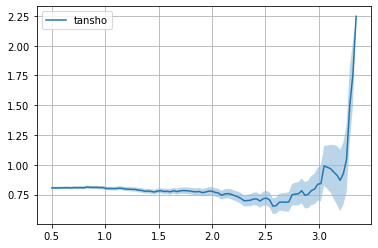

In [63]:
plot(tansho_proper, label="tansho")


In [71]:
fukusho_return

,return_rate,n_hits,std,n_bets
0.50,0.830927,3258.0,0.009821,14007.0
0.53,0.832759,3237.0,0.009963,13633.0
0.56,0.830817,3219.0,0.009848,13285.0
0.59,0.832281,3199.0,0.009937,12924.0
0.62,0.834157,3184.0,0.010004,12583.0
...,...,...,...,...
3.23,0.875000,11.0,0.152965,16.0
3.26,0.885714,10.0,0.154806,14.0
3.29,0.990000,8.0,0.164590,10.0
3.32,1.257143,7.0,0.069568,7.0


In [92]:
print(len(X_2.groupby(level=0)),\
len(X_2))

3452 47118


In [85]:
11/16


0.6875

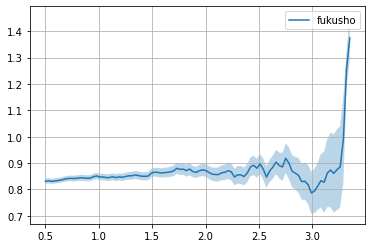

In [72]:
plot(fukusho_return, label="fukusho")

In [76]:
me = ModelEvaluator(lgb_clf, ["Return_tables_all.pickle"])
me.wide_box(X_2)

(19660, 0.82059003051882, 2927, 47.791884769800504)

In [77]:
wide = gain(me.wide_box, X_2)

  0%|          | 0/100 [00:00<?, ?it/s]

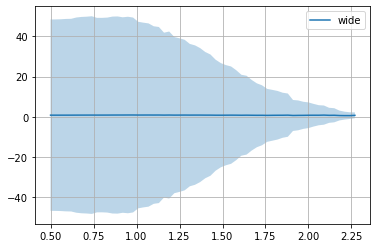

In [79]:
plot(wide, label="wide")

In [80]:
me.sanrenpuku_box(X_2)

(16334, nan, 461, nan)

In [81]:
sanrentan = gain(me.sanrenpuku_box, X_2)

  0%|          | 0/100 [00:00<?, ?it/s]

In [83]:
sanrentan

,return_rate,n_hits,std,n_bets
0.50,NaN,578.0,NaN,22822.0
0.53,NaN,542.0,NaN,20620.0
0.56,NaN,509.0,NaN,18757.0
0.59,NaN,471.0,NaN,16910.0
0.62,NaN,442.0,NaN,15277.0
0.65,NaN,416.0,NaN,13572.0
0.68,NaN,383.0,NaN,12205.0
0.71,NaN,353.0,NaN,10988.0
0.74,NaN,317.0,NaN,9549.0
0.77,NaN,288.0,NaN,8495.0


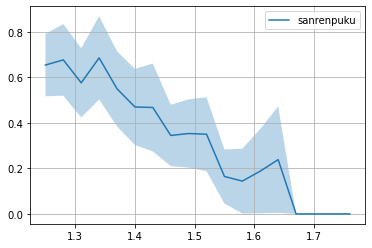

In [84]:
plot(sanrentan, label="sanrenpuku")

In [51]:
me = ModelEvaluator(lgb_clf, ["Return_tables_all.pickle"])
me.sanrenpuku_box(X_2, items=True)

{'n_bets': 16334, 'return_rate': nan, 'n_hits': 461, 'std': nan}

In [22]:
# tableをスクレイプして実際の予測スコアを表示

r = Results(results_all)
r.preprocessing(regression=False)
hr = Horse_Results.read_pickle(["horse_results_19.pickle",
                   'horse_results_20.pickle',
                   'horse_results_21.pickle'])
p = Peds(n_peds_all2)
p.encode()

r.merge_horse_results(hr)
r.merge_peds(p.peds_e)
r.process_categorical()

train, test = split_data(r.data_c)
train, valid = split_data(train)

X_train = train.drop(["rank","date","単勝"],axis=1)
y_train = train["rank"]
X_test = test.drop(["rank","date","単勝"],axis=1)
y_test = test["rank"]
X_valid = valid.drop(["rank","date","単勝"],axis=1)
y_valid = valid["rank"]

lgb_train = lgb_o.Dataset(X_train.values, y_train.values)
lgb_valid = lgb_o.Dataset(X_valid.values, y_valid.values)

params = {
    'objective': 'binary', #今回は0or1の二値予測なのでbinaryを指定
    'random_state': 100
}

#チューニング実行
lgb_clf_o = lgb_o.train(params, lgb_train,
                        valid_sets=(lgb_train, lgb_valid),
                        verbose_eval=100,
                        early_stopping_rounds=10,
                        optuna_seed=100 #optunaのseed固定
                        )

new_params = {
 'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 9.490245203532942e-07,
 'lambda_l2': 6.421168438428032,
 'num_leaves': 36,
 'feature_fraction': 0.4,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 5,
}

#r.data_c = r.data_c.drop(["タイム"],axis=1)


lgb_clf = lgb.LGBMClassifier(**new_params)
lgb_clf.fit(X_train.values, y_train.values)

race_id = ["202106050811"]
st = ShutubaTable.scrape(race_id, "2021/12/26")

st.preprocessing()
st.merge_horse_results(hr)
st.merge_peds(p.peds_e)
st.process_categorical(r.le_horse, r.le_jockey, r.data_pe)

me = ModelEvaluator(lgb_clf,["Return_tables_all.pickle"])


scores = me.predict_proba(st.data_c.drop(['date'], axis=1), train=False)
pred = st.data_c[['馬番']].copy()
pred['score'] = scores
pred.loc['202106050811'].sort_values('score', ascending=False)

# グラフ表示

In [32]:
train2, test2 = split_data(r.data_c)
X_train2 = train2.drop(["rank","date"],axis=1).copy()
y_train2 = train2["rank"]

return_ = gain(me.tansho_return,X_train2)

  0%|          | 0/100 [00:00<?, ?it/s]

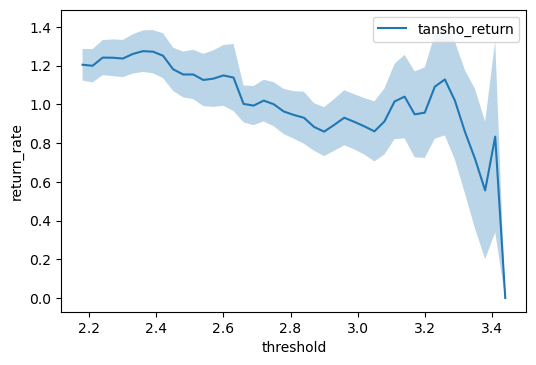

In [33]:
plt.figure(dpi=100)
plt.xlabel('threshold')
plt.ylabel('return_rate')
plt.fill_between(return_.index, y1 = (return_["return_rate"] - return_["std"]),
                                 y2 = (return_["return_rate"] + return_["std"]),alpha=0.3)
return_rate = plt.plot(return_.index, return_["return_rate"], label="tansho_return")
plt.legend()